In [1]:
# imports
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import pandas as pd
import matplotlib.patches as mpatches
import torch
from torch_geometric.data import Data

In [2]:
NUM_FEATURES_PER_SERVICE = 4
service_names = [
    "recommendationservice",
    "productcatalogservice",
    "cartservice",
    "adservice",
    "paymentservice",
    "shippingservice",
    "currencyservice",
    "redis-cart",
    "checkoutservice",
    "frontend",
    "emailservice",
]


# Define which services interact (caller → callee)
service_dependencies = {
    "frontend": [
        "recommendationservice",
        "productcatalogservice",
        "cartservice",
        "checkoutservice",
        "currencyservice",
        "shippingservice",
        "adservice",
    ],
    "recommendationservice": ["productcatalogservice"],
    "cartservice": ["redis-cart"],
    "checkoutservice": [
        "cartservice",
        "paymentservice",
        "shippingservice",
        "currencyservice",
        "productcatalogservice",
        "emailservice",
    ],
    "paymentservice": [],
    "shippingservice": [],
    "emailservice": [],
    "adservice": [],
    "currencyservice": [],
    "productcatalogservice": [],
    "redis-cart": [],
}


traffic_metrics_list = []
for source, destinations in service_dependencies.items():
    for destination in destinations:
        traffic_metrics_list.append(
            {
                "source": source,
                "destination": destination,
                "traffic": random.uniform(0, 100),
            }
        )
traffic_metrics_df = pd.DataFrame(traffic_metrics_list)


def build_graph(metrics, traffic_metrics, num_features):
    # Step 1: build node feature map
    num_services = len(service_names)
    nodes = []
    for i in range(num_services):
        start = i * num_features
        features = metrics[start : start + num_features]
        nodes.append(
            {
                # 'id': i,
                "name": service_names[i],
                "cpu_usage": features[0],
                "mem_usage": features[1],
                "pod_count": features[2],
                "desired_pod_count": features[3],
            }
        )

    # Step 2: build edges
    edges = []
    for i in service_dependencies.keys():
        if service_dependencies[i] != []:
            for j in service_dependencies[i]:
                traffic = float(
                    traffic_metrics[
                        (traffic_metrics["source"] == i)
                        & (traffic_metrics["destination"] == j)
                    ]["traffic"]
                )
                print(traffic)
                edges.append({"source": i, "target": j, "traffic": traffic})
    # Step 3: return graph as dict
    graph = {"nodes": nodes, "edges": edges}
    # print(graph)
    return graph


print(traffic_metrics_df)
graph = build_graph(
    tuple(
        random.randint(1, 100)
        for _ in range(len(service_names) * NUM_FEATURES_PER_SERVICE)
    ),
    traffic_metrics_df,
    4,
)

                   source            destination    traffic
0                frontend  recommendationservice  17.560229
1                frontend  productcatalogservice  95.605373
2                frontend            cartservice  45.926815
3                frontend        checkoutservice  20.239968
4                frontend        currencyservice  67.646125
5                frontend        shippingservice  76.599122
6                frontend              adservice  53.983090
7   recommendationservice  productcatalogservice  64.336944
8             cartservice             redis-cart   9.944204
9         checkoutservice            cartservice  70.133428
10        checkoutservice         paymentservice  47.339030
11        checkoutservice        shippingservice  72.181149
12        checkoutservice        currencyservice  76.620076
13        checkoutservice  productcatalogservice  67.537388
14        checkoutservice           emailservice  64.526928
17.560228896750772
95.60537329428082
45.

/tmp/ipykernel_28095/785110693.py:84: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  traffic = float(


In [3]:
# def visualize_service_graph(graph_dict):
#     """
#     Visualizes a service graph from the given node/edge dictionary.
#     """
#     G = nx.DiGraph()

#     # Add nodes
#     for node in graph_dict['nodes']:
#         G.add_node(node['name'], label=node['name'])

#     # Add edges
#     for edge in graph_dict['edges']:
#         G.add_edge(edge['source'], edge['target'], weight=edge.get('value', 1))

#     # Create position layout
#     pos = nx.shell_layout(G)

#     # Draw nodes with labels
#     node_labels = nx.get_node_attributes(G, 'label')
#     nx.draw_networkx_nodes(G, pos, node_size=900, node_color='red')
#     nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10)

#     # Draw edges
#     edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
#     nx.draw_networkx_edges(G, pos, edge_color='gray', arrows=True, width=edge_weights)

#     plt.title("Microservice Interaction Graph")
#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()


In [4]:
def visualize_service_graph(
    graph_dict,
    figsize=(12, 8),
    node_colors=None,
    edge_colors=None,
    show_weights=True,
    random_colors=True,
    color_seed=None,
):
    """
    Visualizes a service graph with circular layout and styling.

    Args:
        graph_dict: Dictionary with 'nodes' and 'edges' keys
        figsize: Figure size tuple
        node_colors: Dict mapping node names to colors, or single color (overrides random_colors)
        edge_colors: Dict mapping edges to colors, or single color
        show_weights: Whether to show edge weights as labels
        random_colors: Whether to use random colors for nodes (default True)
        color_seed: Seed for random color generation (None for truly random)
    """

    G = nx.DiGraph()

    # Add nodes with attributes
    for node in graph_dict["nodes"]:
        node_type = node.get("type", "service")
        G.add_node(
            node["name"],
            label=node["name"],
            type=node_type,
            size=node.get("size", 1000),
        )

    # Add edges with attributes
    for edge in graph_dict["edges"]:
        weight = edge.get("traffic", 1)
        G.add_edge(
            edge["source"], edge["target"], weight=weight, label=edge.get("label", "")
        )

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Choose layout algorithm

    pos = nx.circular_layout(G)

    # Determine node colors
    if node_colors is None and random_colors:
        # Generate random colors for each node
        if color_seed is not None:
            np.random.seed(color_seed)  # For reproducible colors

        node_colors = []
        for _ in G.nodes():
            # Generate bright, vibrant colors
            hue = np.random.random()
            saturation = 0.7 + np.random.random() * 0.3  # 70-100% saturation
            value = 0.8 + np.random.random() * 0.2  # 80-100% value

            # Convert HSV to RGB
            import colorsys

            r, g, b = colorsys.hsv_to_rgb(hue, saturation, value)
            hex_color = f"#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}"
            node_colors.append(hex_color)
    elif node_colors is None:
        # Default blue color if random_colors is False
        node_colors = ["#45B7D1"] * len(G.nodes())

    # Determine node sizes
    node_sizes = [G.nodes[node].get("size", 1000) for node in G.nodes()]

    # Draw nodes with enhanced styling
    nx.draw_networkx_nodes(
        G,
        pos,
        node_color=node_colors,
        node_size=node_sizes,
        alpha=0.9,
        edgecolors="black",
        linewidths=1.5,
    )

    # Draw node labels with better positioning
    node_labels = nx.get_node_attributes(G, "label")
    nx.draw_networkx_labels(
        G, pos, labels=node_labels, font_size=10, font_weight="bold", font_color="black"
    )

    # Draw edges with varying thickness based on weight
    edge_weights = [G[u][v]["weight"] for u, v in G.edges()]
    max_weight = max(edge_weights) if edge_weights else 1
    edge_widths = [2 + (w / max_weight) * 3 for w in edge_weights]

    edge_color = edge_colors if edge_colors else "#666666"
    nx.draw_networkx_edges(
        G,
        pos,
        edge_color=edge_color,
        arrows=True,
        arrowsize=20,
        arrowstyle="-|>",
        width=edge_widths,
        alpha=0.7,
        connectionstyle="arc3,rad=0.1",
    )

    # Add edge labels if requested
    if show_weights:
        edge_labels = {}
        for u, v in G.edges():
            weight = G[u][v]["weight"]
            label = G[u][v].get("label", "")
            if label:
                edge_labels[(u, v)] = f"{label}\n({weight})"
            else:
                edge_labels[(u, v)] = f"{weight:.2f} kbps"

        nx.draw_networkx_edge_labels(
            G,
            pos,
            edge_labels,
            font_size=8,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8),
        )

    # Add title and styling
    plt.title("Microservice Interaction Graph", fontsize=16, fontweight="bold", pad=20)

    # Remove type-based legend since we're using random colors
    # Legend is now optional and only shown if explicitly using typed nodes
    if node_colors is not None and isinstance(node_colors, dict):
        legend_elements = []
        for node_type, color in node_colors.items():
            legend_elements.append(mpatches.Patch(color=color, label=node_type.title()))
        plt.legend(handles=legend_elements, loc="upper right", bbox_to_anchor=(1.15, 1))

    plt.axis("off")
    plt.tight_layout()
    plt.show()

    return G, pos

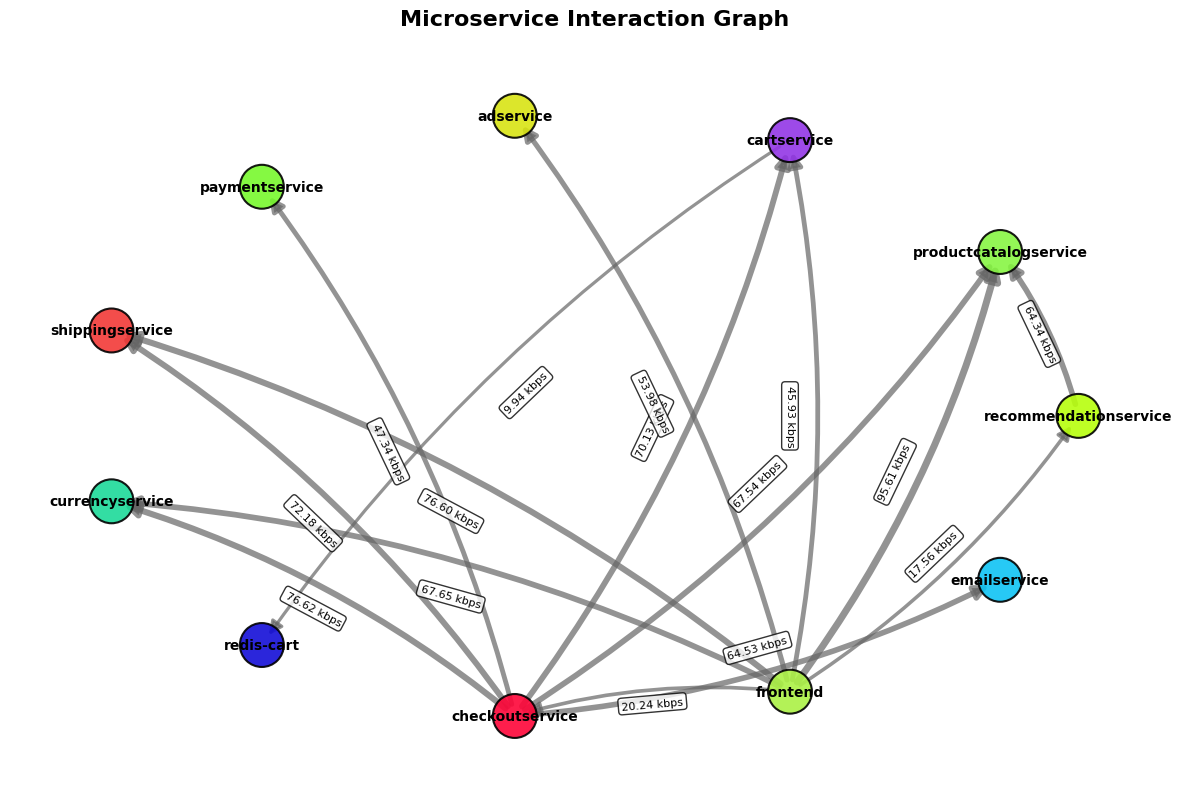

(<networkx.classes.digraph.DiGraph at 0x7cd3b83d58d0>,
 {'recommendationservice': array([1.00000000e+00, 2.70930202e-09]),
  'productcatalogservice': array([0.84125352, 0.54064077]),
  'cartservice': array([0.41541508, 0.90963197]),
  'adservice': array([-0.14231483,  0.98982143]),
  'paymentservice': array([-0.65486067,  0.75574964]),
  'shippingservice': array([-0.95949297,  0.28173259]),
  'currencyservice': array([-0.95949297, -0.28173255]),
  'redis-cart': array([-0.65486073, -0.75574958]),
  'checkoutservice': array([-0.14231501, -0.98982143]),
  'frontend': array([ 0.41541511, -0.90963196]),
  'emailservice': array([ 0.84125346, -0.54064088])})

In [5]:
G = nx.Graph()
visualize_service_graph(graph)

In [6]:
node_list = graph["nodes"]
node_names = [node["name"] for node in node_list]
node_idx_map = {name: idx for idx, name in enumerate(node_names)}

x = torch.tensor(
    [
        [
            node["cpu_usage"],
            node["mem_usage"],
            node["pod_count"],
            node["desired_pod_count"],
        ]
        for node in node_list
    ],
    dtype=torch.float,
)

edge_index = []
edge_attr = []

for edge in graph["edges"]:
    src = node_idx_map[edge["source"]]
    tgt = node_idx_map[edge["target"]]
    edge_index.append([src, tgt])
    edge_attr.append([edge["traffic"]])  # shape = [num_edges, 1]

edge_index = (
    torch.tensor(edge_index, dtype=torch.long).t().contiguous()
)  # shape: [2, num_edges]
edge_attr = torch.tensor(edge_attr, dtype=torch.float)


data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [9]:
data.edge_index

tensor([[ 9,  9,  9,  9,  9,  9,  9,  0,  2,  8,  8,  8,  8,  8,  8],
        [ 0,  1,  2,  8,  6,  5,  3,  1,  7,  2,  4,  5,  6,  1, 10]])

In [ ]:
import torch
import torch.nn as nn
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from torch_geometric.nn import GCNConv


class CustomGNNExtractor(BaseFeaturesExtractor):
    def __init__(
        self,
        observation_space,
        num_nodes,
        node_feature_dim,
        num_edges,
        edge_feature_dim,
        edge_index,
        features_dim=128,
    ):
        """
        Custom GNN Feature Extractor for SB3.

        Args:
            observation_space: Gym space, expects a flat tensor (node and edge features concatenated).
            num_nodes: Number of nodes in the graph.
            node_feature_dim: Features per node.
            num_edges: Number of edges in the graph.
            edge_feature_dim: Features per edge.
            edge_index: Static edge connectivity (shape: [2, num_edges]).
            features_dim: Output dimension of the feature extractor (PPO expects this).
        """
        super().__init__(observation_space, features_dim)

        # Store graph structure information
        self.num_nodes = num_nodes
        self.node_feature_dim = node_feature_dim
        self.num_edges = num_edges
        self.edge_feature_dim = edge_feature_dim

        # Register edge_index as buffer so it's moved to correct device with the model
        self.register_buffer("edge_index", edge_index)

        # GNN layers (GCN)
        self.conv1 = GCNConv(node_feature_dim, 64)
        self.conv2 = GCNConv(64, 64)

        # Final linear layer to map to features_dim
        self.linear = nn.Linear(64, features_dim)

    def forward(self, observations):
        """
        Forward pass.

        Args:
            observations: Tensor of shape (batch_size, flat vector of node and edge features).

        Returns:
            features: Tensor of shape (batch_size, features_dim)
        """

        batch_size = observations.shape[0]

        # Compute the sizes to split the observation back into node and edge features
        node_feat_size = self.num_nodes * self.node_feature_dim
        edge_feat_size = self.num_edges * self.edge_feature_dim

        # Split and reshape the flat observation tensor
        node_feats = observations[:, :node_feat_size].reshape(
            batch_size, self.num_nodes, self.node_feature_dim
        )

        edge_feats = observations[
            :, node_feat_size : node_feat_size + edge_feat_size
        ].reshape(batch_size, self.num_edges, self.edge_feature_dim)

        # Process each graph in the batch separately (since edge features are ignored by GCNConv)
        output_feats = []
        for i in range(batch_size):
            x = node_feats[i]  # Node features for sample i
            # Edge features are ignored in GCNConv by default.
            # You could use them in a custom GNN later if needed.

            # Run GCN layers
            h = torch.relu(self.conv1(x, self.edge_index))
            h = torch.relu(self.conv2(h, self.edge_index))

            # Global mean pooling over nodes to get graph-level representation
            graph_feat = h.mean(dim=0)

            output_feats.append(graph_feat)

        # Stack the outputs back into a batch
        output_feats = torch.stack(output_feats, dim=0)

        # Final linear layer
        return self.linear(output_feats)